# Setup START
***
Skipped in slideshow mode, run manually before!

Ideally, the code would be placed with their corresponding content slides.\
Unfortunately, RISE slideshow mode will not execute SKIP slides and there is no other way to hide them.

In [15]:
%pip install --upgrade pip
# OpenAI Gym related:
%pip install cmake
%pip install atari_py 
'''OpenAI devs actually messed up an indentation
    in the video recorder class in 0.18.x.
    If you want to see videos, wait for a patch or
    use 0.17.x.
'''
%pip install gym[box2d]==0.17.3
%pip install pyvirtualdisplay
%pip install tqdm

# Gridworld related:
%pip install pymdptoolbox

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1

### Setup: OpenAI Gym

In [10]:
from IPython import display
import numpy as np
import base64
import io
import gym
from gym.wrappers import Monitor

if IN_COLAB:
    from pyvirtualdisplay import Display
    d = Display()
    d.start()

'''
Below is a solution to record and display videos for
OpenAI Gym environments.
Why the hassle?
    It works both in Jupyter Notebook and Google Colab!
(The author would like to note how painful it has been
developing this)
'''    

def display_video_from_monitor(monitor):
    '''
    Converts all videos in a monitor to HTML videos
    '''
    if len(monitor.videos) == 0:
        print("No videos to render!")
        return
    for f in monitor.videos:
        video = io.open(f[0], 'r+b').read()
        encoded = base64.b64encode(video)

        display.display(display.HTML(data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>
            """.format(encoded.decode('ascii'))))
    return

def make_video(env, model, max_steps=None):
    mon = Monitor(env, "/data/videos/", force=True)
    state = mon.reset()
    max_steps = max_steps if max_steps is not None else np.inf
    for i in range(max_steps):
        action = model(state)
        state, r, d, _ = mon.step(action)
        if d: break
    else:
        mon.stats_recorder.save_complete()
        mon.stats_recorder.done = True
    mon.reset()
    display_video_from_monitor(mon)
    return mon

### Setup: Grid World

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from mdptoolbox import mdp

class Gridworld():
    def __init__(self, actions, w=4, h=3, rho=1.0, step_reward=0.0, cell_rewards={},
               terminal_states=[], blocked_cells=[]):
        self.actions = actions
        self.w, self.h = w, h
        self.rho = rho
        self.step_reward = step_reward
        self.cell_rewards = cell_rewards
        self.terminal_states = {tuple(x) for x in terminal_states}
        self.blocked_cells = {tuple(x) for x in blocked_cells}

        self.grid = np.zeros((h,w))
        self.states = np.array([[i,j] for i in range(h) for j in range(w)])
        self.num_states = w*h
        self.num_actions = len(actions)
        self.p = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self.r = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self._fill_p()
        self._fill_r()

    def _fill_p(self):
        # computing transition matrix:
        for a in range(self.num_actions):
            for i in range(self.num_states):
                # simulate performing action a_ in state i
                # action a is performed with prob. rho,
                # with prob. 1-rho, any other action is chosen,
                # which results in prob. (1-rho)/(num_moves-1) for
                # a specific action a_ != a
                for a_ in range(self.num_actions):
                    rh, rw = self.simulate_move(self.actions[a_], self.states[i])
                    j_ = rh*self.w + rw
                    prob = self.rho if a == a_ else (1-self.rho)/(self.num_actions-1)
                    self.p[a, i, j_] += prob
                # due to numerical inaccuracies, we need to ensure that each row
                # adds up to exactly 1, not 0.999995, because the solvers
                # really dont seem to like that
                row_sum = self.p[a,i].sum()
                if row_sum != 1:
                    if not np.allclose(row_sum,1, rtol=1e-5, atol=1e-5):
                        raise ValueError(f"Probability error at action{a}, state {i}"
                                         f" with prob. {row_sum}")
                    self.p[a,i] /= row_sum
        return
        # make sure we can't ever leave terminal states
        for (i,j) in self.terminal_states:
            # transition probability from state (i,j) to any other state 
            # must be zero, but one for (i,j)
            index = i*self.w+j
            self.p[:,index,:] = 0
            self.p[:, index, index] = 1

    def _fill_r(self):
        # transitions always give step_reward
        self.r.fill(self.step_reward)

        # ending on a rewarded cell gives the corresponding reward
        for (i,j), reward in self.cell_rewards.items():
            self.r[:,:, i*self.w+j] += reward

        # terminal cells do not give ANY reward after having reached them
        for (i,j) in self.terminal_states:
            k = i*self.w+j
            self.r[:, k, :] = 0

    def simulate_move(self, move, state):
        if self._is_blocked(state): return state
        if self._is_terminal(state): 
            return state
        nm = np.clip(np.array(move)+np.array(state), 0, (self.h-1, self.w-1))
        if self._is_blocked(nm):
            return state
        return nm

    def _is_blocked(self, cy, cx=None):
        # cx: position along grid width
        if cx is None:
            cy, cx = cy
        return (cy, cx) in self.blocked_cells

    def _is_terminal(self, cy, cx=None):
        if cx is None:
            cy, cx = cy
        return (cy, cx) in self.terminal_states
    
    def _plot_policy(self, policy):
        a_l = 0.6 # arrow length
        for (i,j), a in list(zip(self.states, policy)):
            if self._is_terminal(i,j) or self._is_blocked(i,j): continue
           
            dh, dw = self.actions[a]
            if dh == -1:
                y_off = 1 - (1-a_l)/2.
                x_off = 0.5
            elif dh == 0:
                y_off = 0.5
                if dw == -1:
                    x_off = 1 - (1-a_l)/2.0
                elif dw == 1:
                    x_off = (1-a_l)/2.0
                else: raise ValueError("Invalid action to plot!")
            elif dh == 1:
                y_off = (1-a_l)/2.0
                x_off = 0.5
            else: raise ValueError("Invalid action to plot")
            plt.arrow(j+x_off, i+y_off, dw*a_l, dh*a_l, width=0.1, 
                      head_width=0.4, head_length=0.6*0.35, fc="k", ec="k",
                      length_includes_head=True, linewidth=0, overhang=0.3, 
                      zorder=10)
        return

    def _plot_terminal_states(self):
        for (i,j) in self.terminal_states:
            c = plt.Circle((j+0.5,i+0.5), radius=0.3, fill=False, ec="black",
                          lw=3, zorder=6)
            plt.gca().add_patch(c)

    def _plot_blocked_cells(self):
        for (i,j) in self.blocked_cells:
            rect = patches.Rectangle((j,i),1,1, zorder=1, color=(1,219/255,147/255))
            plt.gca().add_patch(rect)        
            
    def _plot_rewards(self, resize_factor):
        
        neg_cm = plt.get_cmap("Reds")
        pos_cm = plt.get_cmap("Greens")
        rmax = max(abs(x) for x in self.cell_rewards.values())
        rmin = -rmax
        for (i,j), r in self.cell_rewards.items():
            plt.text(j+0.05,i+0.95, f"{r:.1f}", zorder=10, weight="bold",
                    size=8*resize_factor)
            # to get the right color, we normalize to 0,255
            r_norm = 1.0 * (r-rmin)/(rmax-rmin)
            cm = pos_cm
            if r < 0:
                r_norm = 1.0 - r_norm
                cm = neg_cm
            col = cm(r_norm)
            print(r, r_norm, col)
            rect = patches.Rectangle((j,i),1,1, zorder=1, color=col)
            plt.gca().add_patch(rect)   
            
    def plot(self, policy=None, start=None, height=None, width=None):
        if height is None and width is None:
            height = self.h
            width = self.w
        if height is None:
            height = self.h*(width/self.w)
        if width is None:
            width = self.w*(height/self.h)
        rf = height/self.h
        fig, ax = plt.subplots(figsize=(width, height))
        if policy is not None:
            self._plot_policy(policy)
        self._plot_terminal_states()
        self._plot_blocked_cells()
        self._plot_rewards(rf)
        ax.grid(zorder=10, lw=1)
        

        plt.xlim(0, self.w)
        plt.ylim(0, self.h)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                        labelbottom=False, right=False, left=False, labelleft=False)
        plt.xticks(range(self.w))
        plt.yticks(range(self.h))
        ax.invert_yaxis()
        plt.title("Grid world")
        plt.show()

# Setup END
***
(Click this cell, and do "Run all above")

# An introduction to Reinforcement Learning
***

In [12]:
try:
    IN_COLAB
    print("Setup was run :)")
except:
    print("Don't forget to run the setup!")

Setup was run :)


# Agenda
***
1. What is Deep RL?
    * Deep Learning vs Deep Reinforcement Learning
2. Types of learning
    * Supervised vs unsupervised vs RL
    * RL in Humans, why are we so good?
3. Reinforcement Learning Framework
    * Agent, Action, State, Reward
4. Environments & Actions
    * Observability, Single VS Multi Agent, Deterministic/Stochastic, Static/Dynamic, Discrete/Continuous
5. RL in the real world
    * Two open problems:
        * Make better simulations
        * Make algorithms that generalize better from simulation to real world
6. Components of an RL agent
    * Policy, the behavior function, probability of taking $a_t$ when in state $s_t$
    * Value function, how good is each state/action in terms of expected future reward
        * $V_\pi(s)=E\left[\sum_{t=0}^{\infty}\gamma^t r_t\mid s_0 = s\right]$
    * Model, agent's representation of the environment
7. Meaning of Life: Maximize Reward
    * Future reward, discounted reward
        * Sparse reward problem
        * Credit assignment problem
8. Robot in a room/Gridworld:
    * Example to show the impact of reward structure and environment on the optimal policy
    * WE HAVE CODE NOW, WOOOOO
9. Types of RL (several ways to taxonomize exist!)
    * Model-based
        * learn a model of the world through interaction, then plan ahead using the model
    * Value-based (off policy)
        * Learn the values for states or states/actions
            * Constantly update how good it is to take action $a$ in state $s$
            * Act by choosing the best action in state. Exploration is needed!
    * Policy-based
        * Learning the right behavior function that maps state to action
        * Act by sampling policy, exploration already included
10. Taxonomy by OpenAI
    * Is this needed?
    
TODO:
DQN oder A2C
+ Daran gebundene Challenge

# Grid World
***

1 0.505 (0.4454901960784314, 0.7640138408304499, 0.4581314878892734, 1.0)
-100 1.0 (0.403921568627451, 0.0, 0.05098039215686274, 1.0)
-4 0.52 (0.9761937716262975, 0.3838831218762015, 0.2698961937716263, 1.0)


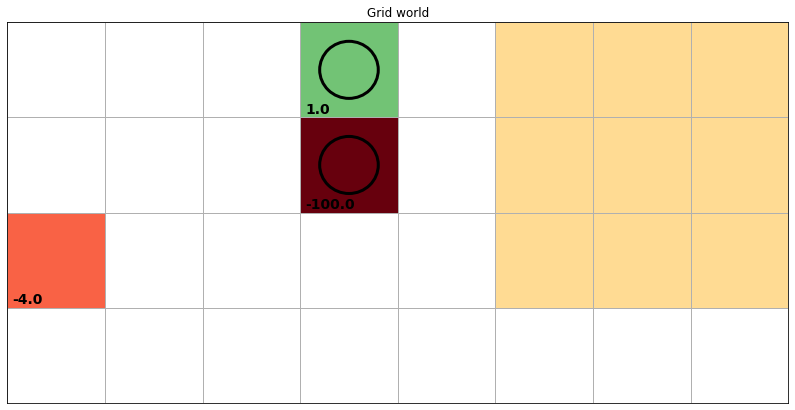

In [13]:
w=8; h=4; rho=0.7; step_reward=0.04;

actions = np.array([
    [-1,0], # UP
    [1,0], # DOWN 
    [0,-1], # Left
    [0,1], # Right
])
cell_rewards={
    (0,3): 1,
    (1,3): -100,
    #(1,6): 1,
    (2,0): -4,
}
terminal_states=[
    [0,3],
    [1,3],
]
blocked=[
    [0,5],
    [1,5],
    [2,5],
    [0,6],
    [1,6],
    [2,6],
    [0,7],
    [1,7],
    [2,7],
]

gw  = Gridworld(w=w, h=h, rho=rho, step_reward=step_reward,
                cell_rewards=cell_rewards, actions=actions,
                terminal_states=terminal_states, blocked_cells=blocked)
gw.plot(height=7)

  Iteration		Number of different actions
    1		  12
    2		  6
    3		  7
    4		  5
    5		  3
    6		  1
    7		  0
Iterating stopped, unchanging policy found.
(1, 1, 2, 0, 1, 0, 0, 0, 3, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0)
1 0.505 (0.4454901960784314, 0.7640138408304499, 0.4581314878892734, 1.0)
-100 1.0 (0.403921568627451, 0.0, 0.05098039215686274, 1.0)
-4 0.52 (0.9761937716262975, 0.3838831218762015, 0.2698961937716263, 1.0)


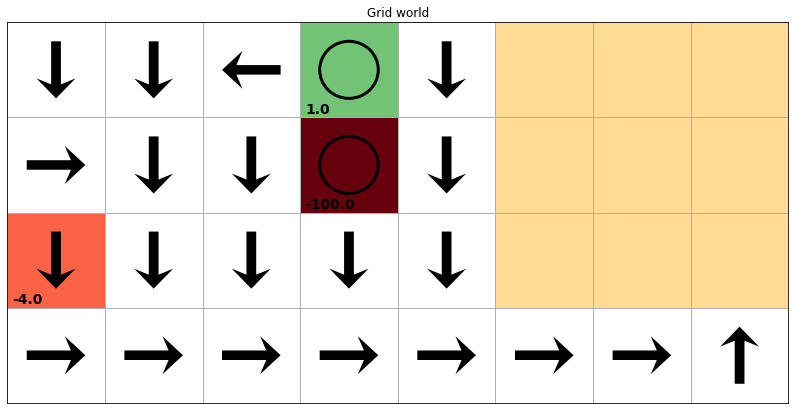

(31.116759255885647,
 30.808753403933032,
 26.08306570040627,
 1.4758520067390301e-12,
 14.53289844929299,
 39.99999910593029,
 39.99999910593029,
 39.99999910593029,
 31.14805737857597,
 31.426707664649914,
 17.946010834113928,
 1.639438441625813e-13,
 16.429608902933595,
 39.99999910593029,
 39.99999910593029,
 39.99999910593029,
 33.14420193634888,
 33.468348442260506,
 31.689955324683943,
 21.26212471825277,
 33.31396368831372,
 39.99999910593029,
 39.99999910593029,
 39.99999910593029,
 33.94525591968283,
 34.62303487733042,
 34.87712695792741,
 35.361410732201314,
 37.438145099583835,
 38.32032718263086,
 38.44395167309527,
 38.459387574247486)

In [17]:
#vi = mdp.ValueIteration(gw.p, gw.r, 0.9, max_iter=1e5)
vi = mdp.PolicyIteration(gw.p, gw.r, 0.999)
vi.setVerbose()
vi.run()
print(vi.policy)
gw.plot(policy=vi.policy, height=7)
vi.V

# OpenAI Gym
***

In [14]:
env = gym.make("BipedalWalker-v3")
model = lambda state: env.action_space.sample()
mon = make_video(env, model, max_steps=100)
mon.close()

c:\users\nikla\workspace\jupyter-notebooks\env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
